In [1]:
import pickle
import pandas as pd
import numpy as np

from airsenal.framework.schema import session, Result, Fixture

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
seasons = ["1718", "1819", "1920", "2021"]

models_fifa = {}
models_nofifa = {}

for season in seasons:
    with open(f"data/models_fifa_{season}.pkl", "rb") as f:
        models_fifa[season] = pickle.load(f)
    with open(f"data/models_nofifa_{season}.pkl", "rb") as f:
        models_nofifa[season] = pickle.load(f)


In [3]:
for season in seasons:
    for model in models_fifa[season].values():
        model.add_new_team("DUMMY")
    for model in models_nofifa[season].values():
        model.add_new_team("DUMMY")


/Users/jroberts/opt/anaconda3/envs/airsenalenv/lib/python3.7/site-packages/bpl/models.py:438: UserWarning: You haven't provided features for DUMMY. Assuming X is the average of known teams. For better forecasts, provide X.
  " For better forecasts, provide X.".format(team_name)


In [4]:
MAX_GOALS = 8


def get_prob_goals(model, team_h, team_a, max_goals=MAX_GOALS):
    prob_score_h = [
        model.score_n_probability(n, team_h, team_a)
        for n in range(max_goals)
    ]
    prob_score_a = [
        model.score_n_probability(n, team_a, team_h, home=False)
        for n in range(max_goals)
    ]

    return prob_score_h, prob_score_a


def get_prob_goals_season(team_h, team_a, season, max_goals=MAX_GOALS):    
    gameweeks = models_fifa[season].keys()
    
    goals_h_fifa = {}
    goals_h_nofifa = {}
    goals_a_fifa = {}
    goals_a_nofifa = {}

    for gameweek in gameweeks:
        model_fifa = models_fifa[season][gameweek]
        model_nofifa = models_nofifa[season][gameweek]

        goals_h_fifa[gameweek], goals_a_fifa[gameweek] = get_prob_goals(
            model_fifa, team_h, team_a, max_goals=max_goals
        )

        goals_h_nofifa[gameweek], goals_a_nofifa[gameweek] = get_prob_goals(
            model_nofifa, team_h, team_a, max_goals=max_goals
        )

    return goals_h_fifa, goals_h_nofifa, goals_a_fifa, goals_a_nofifa


def expected_value(values, probabilities):
    return sum([
        values[i] * probabilities[i]
        for i in range(len(values))
    ])


def get_exp_goals(model, team_h, team_a, max_goals=MAX_GOALS):
    prob_goals_h, prob_goals_a = get_prob_goals(
        model, team_h, team_a, max_goals=MAX_GOALS
    )
    exp_h = expected_value(range(max_goals), prob_goals_h)
    exp_a = expected_value(range(max_goals), prob_goals_a)

    return exp_h, exp_a
    

In [5]:
def plot_prob_goals(
    team_h, team_a,
    season, gameweek,
    ax=None, max_goals=MAX_GOALS
):
    prob_score_h_fifa, _ = get_prob_goals(
        models_fifa[season][gameweek],
        team_h, team_a, max_goals=max_goals
    )
    
    prob_score_h_nofifa, _ = get_prob_goals(
        models_nofifa[season][gameweek],
        team_h, team_a, max_goals=max_goals
    )
    
    max_prob = 1.1 * max(
        prob_score_h_fifa +
        prob_score_h_nofifa
    )

    if ax is None:
        ax = plt.gca()
    ax.plot(range(max_goals), prob_score_h_fifa, "-o", label="FIFA")
    ax.plot(range(max_goals), prob_score_h_nofifa, "-o", label="No FIFA")
    ax.set_ylim([0, max_prob])
    ax.set_xlim([-0.5, max_goals])
    ax.set_title(f"{season} GW{gameweek}: {team_h} vs. {team_a}")
    ax.set_xlabel("No. Goals")
    ax.set_ylabel("Probability")
    ax.legend()


def plot_prob_goals_season(team_h, team_a, season, max_goals=MAX_GOALS):
    gameweeks = models_fifa[season].keys()
    
    for gameweek in gameweeks:
        fig = plt.figure(figsize=(6,4))
        plot_prob_goals(team_h, team_a, season, gameweek,
                        max_goals=max_goals, ax=fig.gca())

(0.0, 0.45)

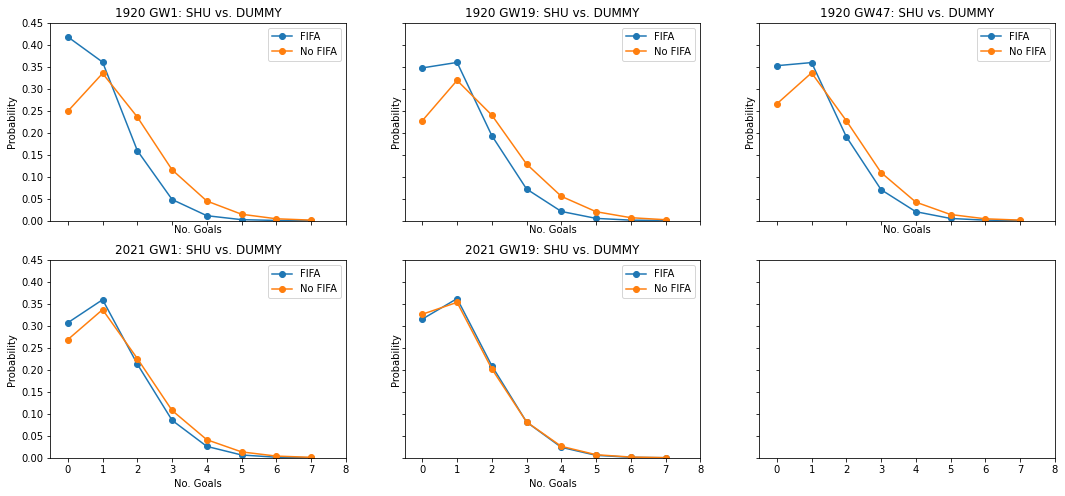

In [6]:
fig, ax = plt.subplots(2, 3, figsize=(18, 8), sharex=True, sharey=True)

plot_prob_goals(
    "SHU", "DUMMY",
    "1920", 1,
    ax=ax[0, 0]
)

plot_prob_goals(
    "SHU", "DUMMY",
    "1920", 19,
    ax=ax[0, 1]
)

plot_prob_goals(
    "SHU", "DUMMY",
    "1920", 47,
    ax=ax[0, 2]
)

plot_prob_goals(
    "SHU", "DUMMY",
    "2021", 1,
    ax=ax[1, 0]
)

plot_prob_goals(
    "SHU", "DUMMY",
    "2021", 19,
    ax=ax[1, 1]
)

ax[0, 0].set_ylim([0, 0.45])

(0.0, 0.4)

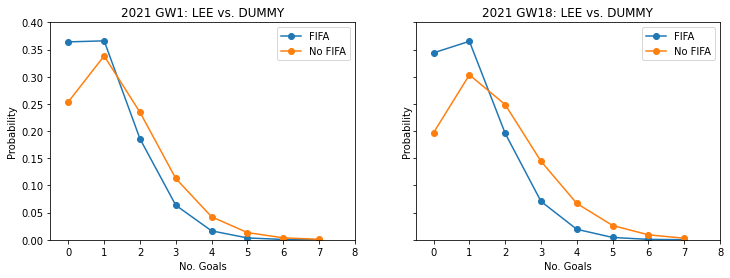

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True)

plot_prob_goals(
    "LEE", "DUMMY",
    "2021", 1,
    ax=ax[0]
)

plot_prob_goals(
    "LEE", "DUMMY",
    "2021", 18,
    ax=ax[1]
)

ax[0].set_ylim([0, 0.4])

/Users/jroberts/opt/anaconda3/envs/airsenalenv/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


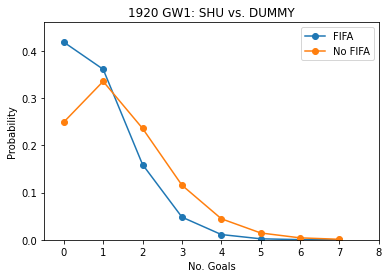

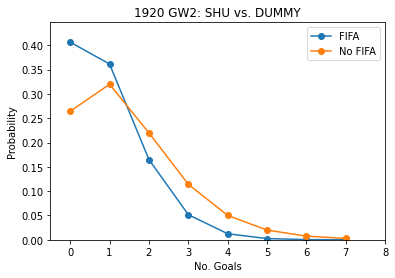

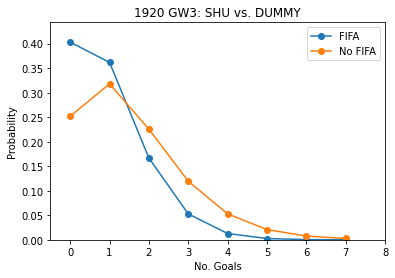

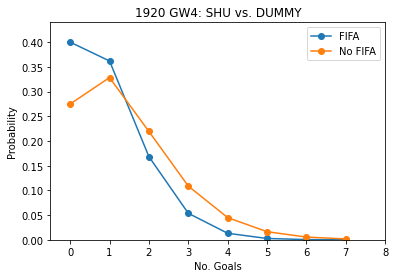

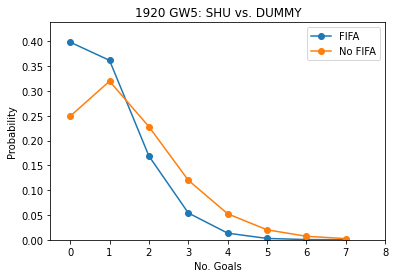

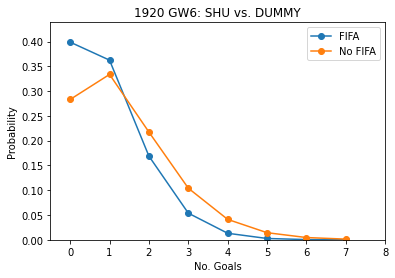

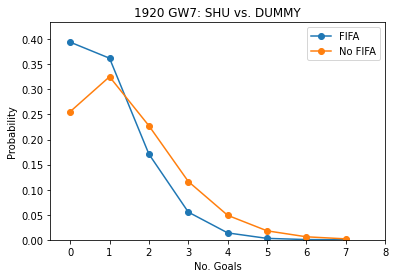

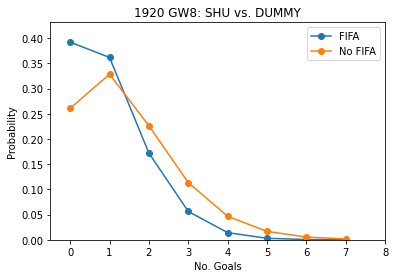

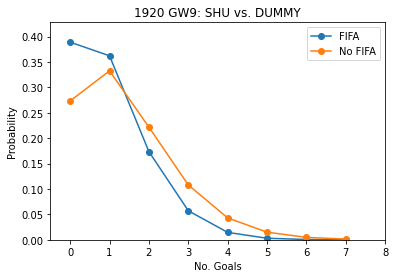

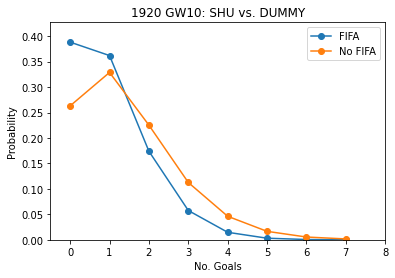

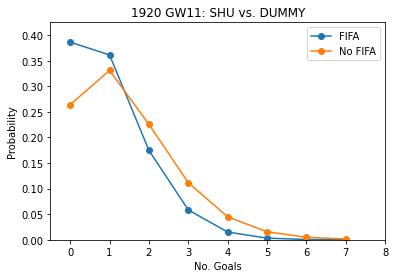

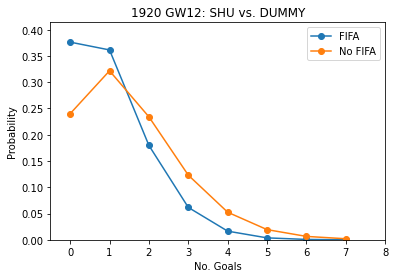

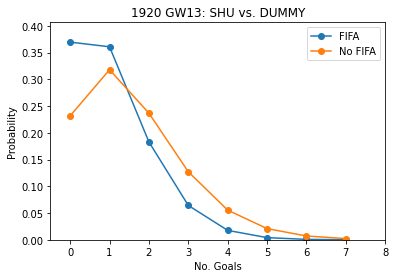

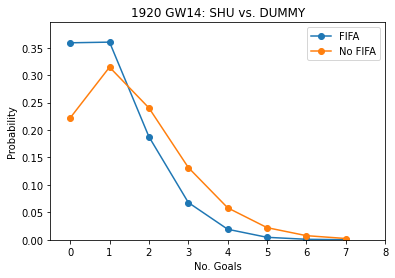

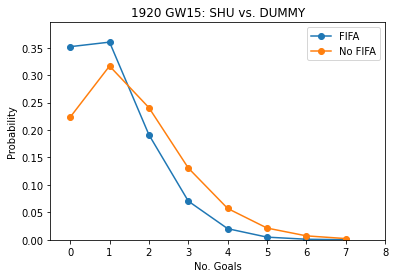

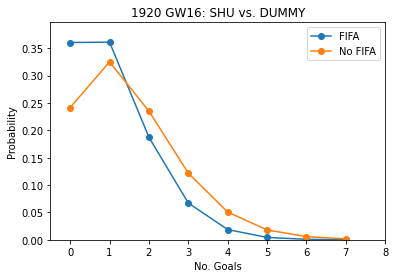

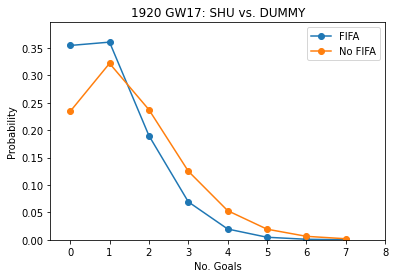

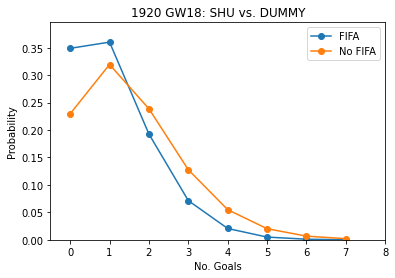

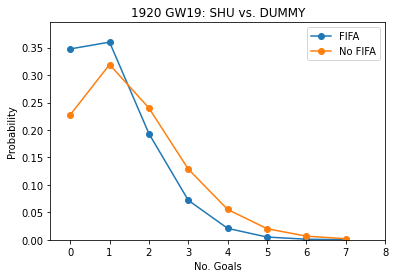

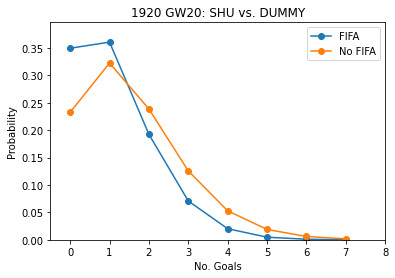

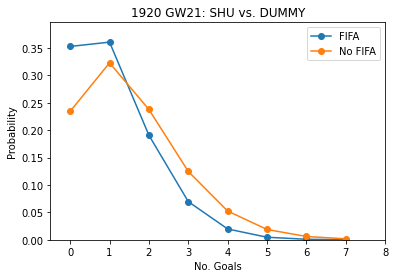

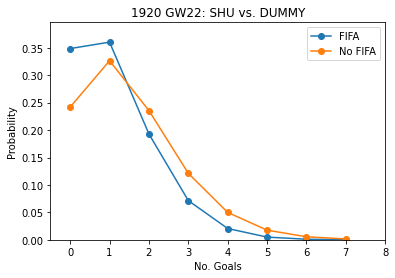

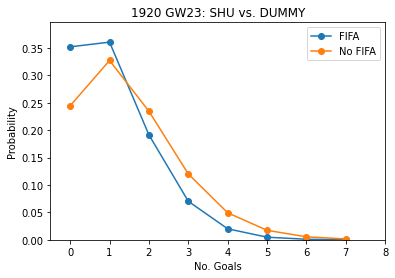

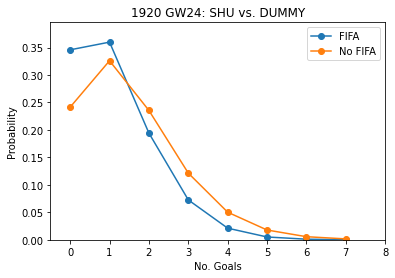

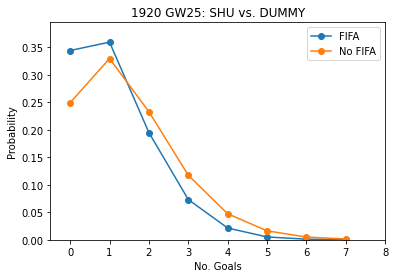

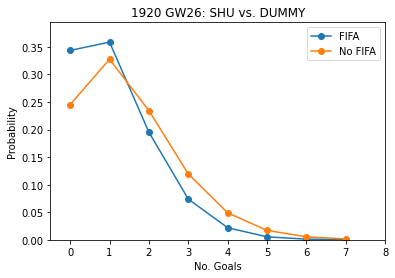

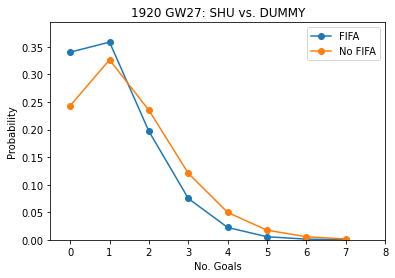

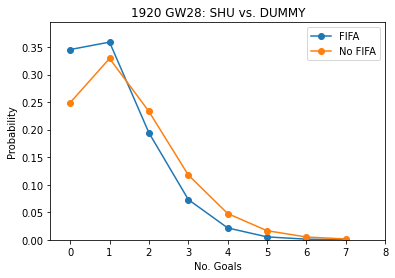

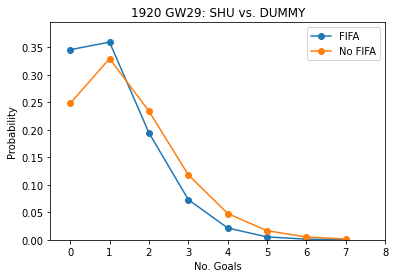

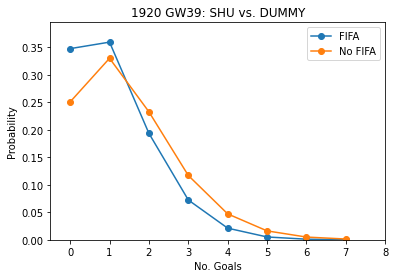

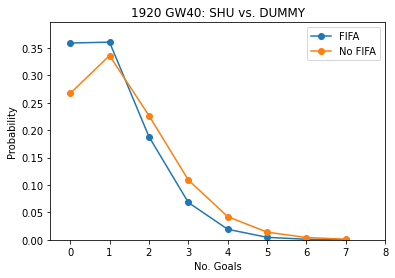

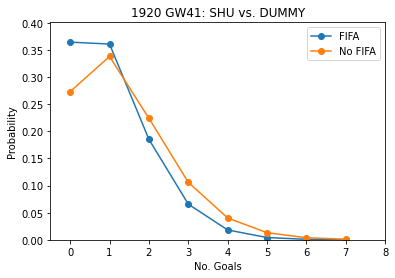

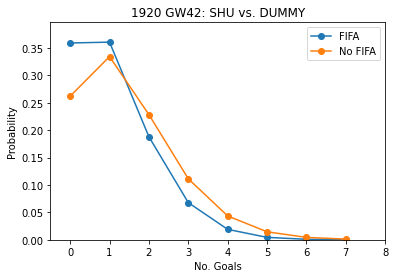

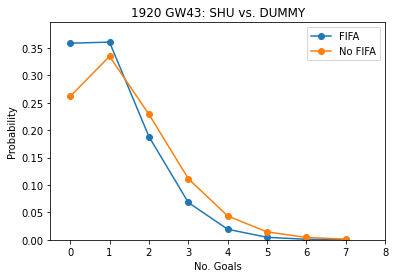

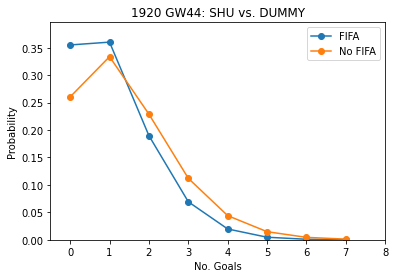

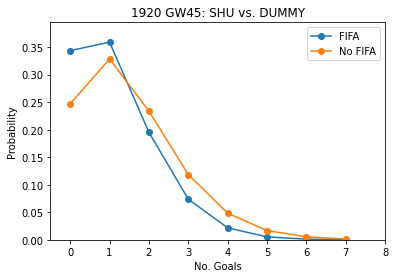

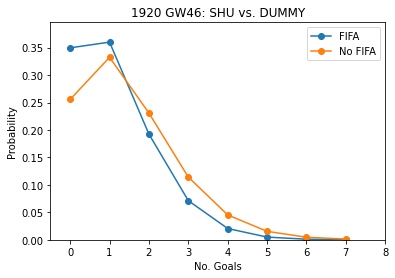

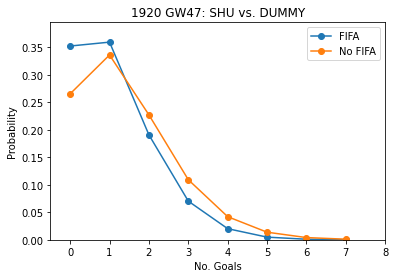

In [8]:
plot_prob_goals_season("SHU", "DUMMY", "1920")

In [9]:
results = pd.read_sql(
    session.query(
        Fixture.season,
        Fixture.gameweek,
        Fixture.home_team,
        Result.home_score,
        Result.away_score,
        Fixture.away_team
    ).join(Fixture).statement,
    session.bind
)
results.sort_values(by=["season", "gameweek"], inplace=True)

results.head()

,season,gameweek,home_team,home_score,away_score,away_team
1130,1718,1,MUN,4,0,WHU
1131,1718,1,NEW,0,2,TOT
1132,1718,1,BHA,0,2,MCI
1133,1718,1,WBA,1,0,BOU
1134,1718,1,SOU,0,0,SWA


In [10]:
def prob_result_goals(
    model, team_h, goals_h, team_a, goals_a
):
    prob_score_h = model.score_n_probability(
        goals_h, team_h, team_a
    )
    prob_score_a = model.score_n_probability(
        goals_a, team_a, team_h, home=False
    )
    
    return prob_score_h, prob_score_a


In [11]:
for idx, r in results.iterrows():
    try:
        model_fifa = models_fifa[r["season"]][r["gameweek"]]
        model_nofifa = models_nofifa[r["season"]][r["gameweek"]]

        prob_fifa_h, prob_fifa_a = prob_result_goals(
            model_fifa,
            r["home_team"],
            r["home_score"],
            r["away_team"],
            r["away_score"],
        )

        prob_nofifa_h, prob_nofifa_a = prob_result_goals(
            model_nofifa,
            r["home_team"],
            r["home_score"],
            r["away_team"],
            r["away_score"],
        )
        
        exp_fifa_h, exp_fifa_a = get_exp_goals(
            model_fifa,
            r["home_team"],
            r["away_team"],
        )

        exp_nofifa_h, exp_nofifa_a = get_exp_goals(
            model_nofifa,
            r["home_team"],
            r["away_team"],
        )
        
        results.loc[idx, "prob_fifa_h"] = prob_fifa_h
        results.loc[idx, "prob_fifa_a"] = prob_fifa_a
        results.loc[idx, "prob_nofifa_h"] = prob_nofifa_h
        results.loc[idx, "prob_nofifa_a"] = prob_nofifa_a

        results.loc[idx, "exp_fifa_h"] = exp_fifa_h
        results.loc[idx, "exp_fifa_a"] = exp_fifa_a
        results.loc[idx, "exp_nofifa_h"] = exp_nofifa_h
        results.loc[idx, "exp_nofifa_a"] = exp_nofifa_a

    except KeyError:
        print(f"Failed: {r['season']} {r['gameweek']} {r['home_team']} {r['away_team']}")


Failed: 1718 1 MUN WHU
Failed: 1718 1 NEW TOT
Failed: 1718 1 BHA MCI
Failed: 1718 1 WBA BOU
Failed: 1718 1 SOU SWA
Failed: 1718 1 EVE STK
Failed: 1718 1 CRY HUD
Failed: 1718 1 CHE BUR
Failed: 1718 1 WAT LIV
Failed: 1718 1 ARS LEI


In [22]:
results["err_fifa_h"] = results["exp_fifa_h"] - results["home_score"]
results["err_fifa_a"] = results["exp_fifa_a"] - results["away_score"]
results["err_nofifa_h"] = results["exp_nofifa_h"] - results["home_score"]
results["err_nofifa_a"] = results["exp_nofifa_a"] - results["away_score"]

In [23]:
results

,season,gameweek,home_team,home_score,away_score,away_team,prob_fifa_h,prob_fifa_a,prob_nofifa_h,prob_nofifa_a,exp_fifa_h,exp_fifa_a,exp_nofifa_h,exp_nofifa_a,err_fifa_h,err_fifa_a,err_nofifa_h,err_nofifa_a
1130,1718,1,MUN,4,0,WHU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1131,1718,1,NEW,0,2,TOT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1132,1718,1,BHA,0,2,MCI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1133,1718,1,WBA,1,0,BOU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1134,1718,1,SOU,0,0,SWA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1318,2021,19,ARS,3,0,NEW,0.160831,0.385960,0.165552,0.415422,1.801884,0.954605,1.850438,0.882383,-1.198116,0.954605,-1.149562,0.882383
1319,2021,19,WHU,2,1,WBA,0.268352,0.363755,0.263968,0.357827,1.911863,0.881014,1.770767,0.820902,-0.088137,-0.118986,-0.229233,-0.179098
1320,2021,19,LEI,2,0,CHE,0.227705,0.252860,0.245646,0.243213,1.287179,1.378927,1.459473,1.420981,-0.712821,1.378927,-0.540527,1.420981
1321,2021,19,MCI,2,0,AVL,0.228619,0.500654,0.230413,0.486104,2.835706,0.693893,2.802418,0.726192,0.835706,0.693893,0.802418,0.726192


In [13]:
(np.log(results["prob_fifa_h"]) + np.log(results["prob_fifa_a"])).sum()

-3819.6615393380293

In [14]:
(np.log(results["prob_nofifa_h"]) + np.log(results["prob_nofifa_a"])).sum()

-3815.416426912667

In [15]:
results.groupby("season")[
    ["prob_fifa_h", "prob_fifa_a", "prob_nofifa_h", "prob_nofifa_a"]
].describe().T

season                     1718        1819        1920        2021
prob_fifa_h   count  370.000000  380.000000  380.000000  183.000000
              mean     0.257875    0.256018    0.256047    0.257382
              std      0.123202    0.105592    0.099228    0.104028
              min      0.007952    0.012464    0.009786    0.000026
              25%      0.171638    0.193349    0.199566    0.185177
              50%      0.253320    0.256305    0.259581    0.264019
              75%      0.349216    0.348196    0.346173    0.355151
              max      0.606161    0.575496    0.543772    0.463969
prob_fifa_a   count  370.000000  380.000000  380.000000  183.000000
              mean     0.306607    0.292796    0.291841    0.271523
              std      0.149758    0.128343    0.119893    0.127740
              min      0.006216    0.003984    0.000008    0.001480
              25%      0.192331    0.203370    0.204104    0.173832
              50%      0.316635    0.315025    0.329094    0.312752
              75%      0.362315    0.363820    0.363698    0.362067
              max      0.710400    0.655697    0.648544    0.582910
prob_nofifa_h count  370.000000  380.000000  380.000000  183.000000
              mean     0.254495    0.255325    0.255460    0.254508
              std      0.113848    0.103920    0.094133    0.100918
              min      0.007621    0.017993    0.014112    0.000033
              25%      0.174468    0.193934    0.206481    0.183970
              50%      0.255054    0.256313    0.257148    0.263168
              75%      0.346816    0.347496    0.336845    0.346257
              max      0.558323    0.583379    0.502203    0.455579
prob_nofifa_a count  370.000000  380.000000  380.000000  183.000000
              mean     0.302318    0.291241    0.289275    0.272619
              std      0.137392    0.127012    0.114751    0.127798
              min      0.007712    0.004831    0.000020    0.001506
              25%      0.198804    0.202610    0.204747    0.180621
              50%      0.329578    0.316988    0.326318    0.319438
              75%      0.360481    0.362328    0.362651    0.361684
              max      0.708116    0.649899    0.650348    0.602730

FIFA Log Prob -49.29443519184737
No FIFA Log Prob -48.93473932268804
FIFA Sq Err 36.35531847236011
No FIFA Sq Err 35.89156891980317


Text(0.5, 1.0, 'Mean Sq Err')

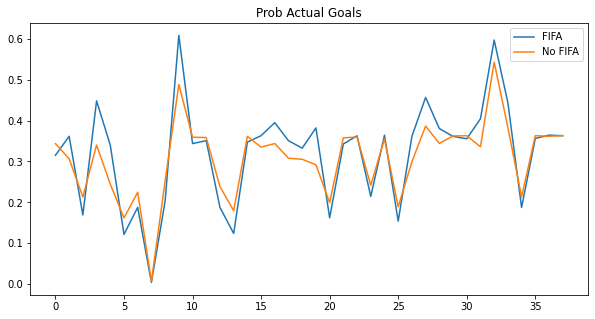

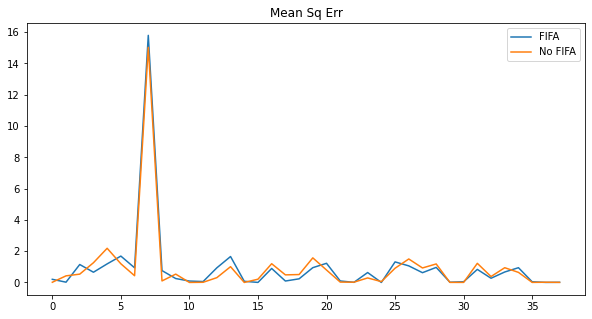

In [33]:
team = "AVL"
season = "1920"

team_r = results[
    (results["season"] == season) &
    ((results["home_team"] == team) | (results["away_team"] == team))
]

team_fifa = []
team_nofifa = []
for idx, r in team_r.iterrows():
    if r["home_team"] == team:
        team_fifa.append(r["prob_fifa_h"])
        team_nofifa.append(r["prob_nofifa_h"])
    elif r["away_team"] == team:
        team_fifa.append(r["prob_fifa_a"])
        team_nofifa.append(r["prob_nofifa_a"])
    else:
        raise ValueError("Not SHU")

print("FIFA Log Prob", np.log(team_fifa).sum())
print("No FIFA Log Prob", np.log(team_nofifa).sum())

plt.figure(figsize=(10, 5))
plt.plot(team_fifa, label="FIFA")
plt.plot(team_nofifa, label="No FIFA")
plt.legend()
plt.title("Prob Actual Goals")

team_fifa = []
team_nofifa = []
for idx, r in team_r.iterrows():
    if r["home_team"] == team:
        team_fifa.append(r["err_fifa_h"]**2)
        team_nofifa.append(r["err_nofifa_h"]**2)
    elif r["away_team"] == team:
        team_fifa.append(r["err_fifa_a"]**2)
        team_nofifa.append(r["err_nofifa_a"]**2)
    else:
        raise ValueError("Not SHU")

print("FIFA Sq Err", sum(team_fifa))
print("No FIFA Sq Err", sum(team_nofifa))

plt.figure(figsize=(10, 5))
plt.plot(team_fifa, label="FIFA")
plt.plot(team_nofifa, label="No FIFA")
plt.legend()
plt.title("Mean Sq Err")

In [19]:
"""
plt.figure(figsize=(12,4))

plt.subplot(1, 2, 1)
plt.plot(mean_goals_h_fifa.keys(), mean_goals_h_fifa.values(), label="FIFA")
plt.plot(mean_goals_h_nofifa.keys(), mean_goals_h_nofifa.values(), label="No FIFA")
plt.xlabel("Gameweek")
plt.ylabel("Exp. Goals")
plt.title(team_h)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(mean_goals_a_fifa.keys(), mean_goals_a_fifa.values(), label="FIFA")
plt.plot(mean_goals_a_nofifa.keys(), mean_goals_a_nofifa.values(), label="No FIFA")
plt.xlabel("Gameweek")
plt.ylabel("Exp. Goals")
plt.title(team_a)
plt.legend()
"""

'\nplt.figure(figsize=(12,4))\n\nplt.subplot(1, 2, 1)\nplt.plot(mean_goals_h_fifa.keys(), mean_goals_h_fifa.values(), label="FIFA")\nplt.plot(mean_goals_h_nofifa.keys(), mean_goals_h_nofifa.values(), label="No FIFA")\nplt.xlabel("Gameweek")\nplt.ylabel("Exp. Goals")\nplt.title(team_h)\nplt.legend()\n\nplt.subplot(1, 2, 2)\nplt.plot(mean_goals_a_fifa.keys(), mean_goals_a_fifa.values(), label="FIFA")\nplt.plot(mean_goals_a_nofifa.keys(), mean_goals_a_nofifa.values(), label="No FIFA")\nplt.xlabel("Gameweek")\nplt.ylabel("Exp. Goals")\nplt.title(team_a)\nplt.legend()\n'

In [20]:
"""
for gameweek in gameweeks:
    team_idx = {key: val-1 for key, val in models_fifa[gameweek].team_indices.items()}
    plt.figure()
    sns.kdeplot(models_fifa[gameweek].a[:, team_idx[team_h]], label="FIFA")
    sns.kdeplot(models_nofifa[gameweek].a[:, team_idx[team_h]], label="No FIFA")
    plt.title(f"{team_h}: a, GW: {gameweek}")
    plt.legend()
"""

'\nfor gameweek in gameweeks:\n    team_idx = {key: val-1 for key, val in models_fifa[gameweek].team_indices.items()}\n    plt.figure()\n    sns.kdeplot(models_fifa[gameweek].a[:, team_idx[team_h]], label="FIFA")\n    sns.kdeplot(models_nofifa[gameweek].a[:, team_idx[team_h]], label="No FIFA")\n    plt.title(f"{team_h}: a, GW: {gameweek}")\n    plt.legend()\n'

In [21]:
"""
a_mean = models_fifa[gameweek].a.mean(axis=0)
b_mean = models_fifa[gameweek].b.mean(axis=0)

a_conf95 = np.abs(np.quantile(models_fifa[gameweek].a,[0.025, 0.975], axis=0) - a_mean)
b_conf95 = np.abs(np.quantile(models_fifa[gameweek].b, [0.025, 0.975], axis=0) - b_mean)
a_conf80 = np.abs(np.quantile(models_fifa[gameweek].a,[0.1, 0.9], axis=0) - a_mean)
b_conf80 = np.abs(np.quantile(models_fifa[gameweek].b, [0.1, 0.9], axis=0) - b_mean)
"""

'\na_mean = models_fifa[gameweek].a.mean(axis=0)\nb_mean = models_fifa[gameweek].b.mean(axis=0)\n\na_conf95 = np.abs(np.quantile(models_fifa[gameweek].a,[0.025, 0.975], axis=0) - a_mean)\nb_conf95 = np.abs(np.quantile(models_fifa[gameweek].b, [0.025, 0.975], axis=0) - b_mean)\na_conf80 = np.abs(np.quantile(models_fifa[gameweek].a,[0.1, 0.9], axis=0) - a_mean)\nb_conf80 = np.abs(np.quantile(models_fifa[gameweek].b, [0.1, 0.9], axis=0) - b_mean)\n'